# Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow.keras.layers import Dense
output_layer = Dense(10)

# or:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
matplotlib 2.1.2
numpy 1.16.4
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.0.0-dev20190528
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [5]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

**Note**: The preview version of TensorFlow 2.0 shows up as version 1.13. That's okay. To test that this behaves like TF 2.0, we verify that `tf.function()` is present.

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [7]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [8]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  44, 127,
        182, 185, 161, 120,  55,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 198, 251, 255,
        251, 249, 247, 255, 252, 214, 100,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 233, 252, 237, 239,
        234, 237, 235, 237, 237, 254, 227,   0,   0,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,  16, 210, 225, 215, 175,
        217, 216, 193, 196, 226, 221, 209,  50,   0,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   2,   0,   0, 199, 229, 232, 230, 245, 204,
        219, 253, 245, 207, 194, 223, 231, 236, 235,   0,   0,   3,   0,
          0,   0],
       [  

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

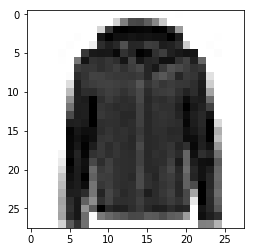

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [12]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

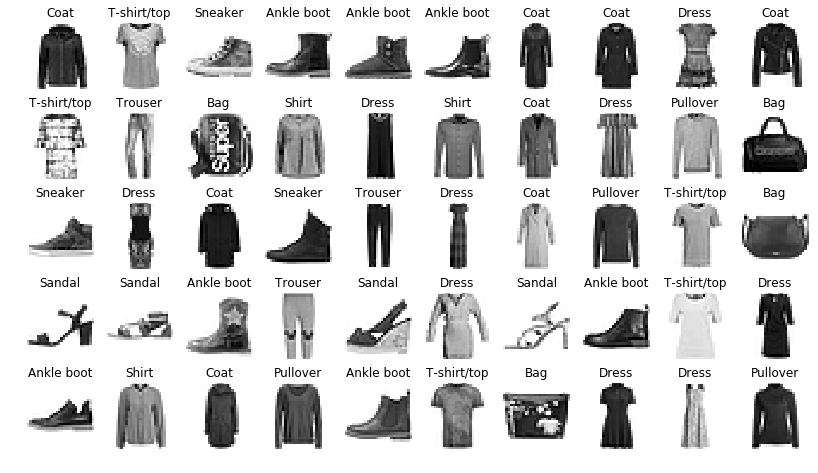

In [15]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `"sgd"` optimizer (stochastic gradient descent). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

### 2.8)
call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

## Exercise 2 - Solution

### 2.1)
Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:
  * a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)构建模型
Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.layers

### 2.3)显示模型结构
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


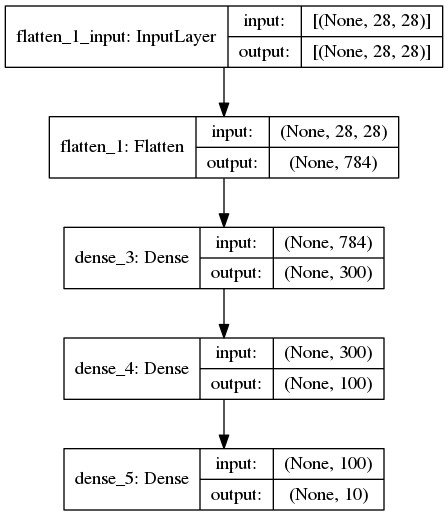

In [20]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [21]:
%%html
<img src="my_mnist_model.png" />

**Warning**: at the present, you need `from tensorflow.python.keras.utils.vis_utils import model_to_dot`, instead of simply `keras.utils.model_to_dot`. See [TensorFlow issue 24639](https://github.com/tensorflow/tensorflow/issues/24639).

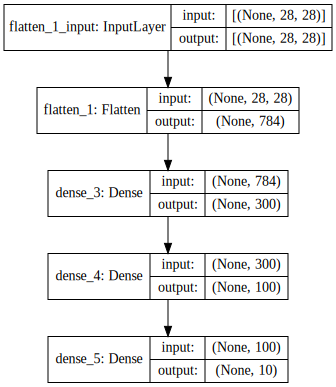

In [22]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 2.4)优化模型
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `"sgd"` optimizer (stochastic gradient descent). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

### 2.5)训练模型
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [24]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

W0627 22:42:20.028981 139815681652480 deprecation.py:323] From /home/tf2/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 103us/sample - loss: 14.5048 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 2/10
55000/55000 [==============================] - 6s 100us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 3/10
55000/55000 [==============================] - 5s 100us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 4/10
55000/55000 [==============================] - 5s 100us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 6/10
55000/55000 [==============================] - 6s 101us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 7/10
55000/55000 [================

In [25]:
history.history

{'accuracy': [0.100090906,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727,
  0.10012727],
 'loss': [14.50476483112682,
  14.504234296902743,
  14.504234285111862,
  14.504234271933816,
  14.504234279424495,
  14.504234304532138,
  14.50423430189653,
  14.504234303977272,
  14.504234288441051,
  14.50423428663774],
 'val_accuracy': [0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986,
  0.0986],
 'val_loss': [14.528851023864746,
  14.528851000976562,
  14.52885098876953,
  14.52885103149414,
  14.528850982666016,
  14.528851020812988,
  14.528851007080078,
  14.528850978088379,
  14.528851020812988,
  14.528851063537598]}

### 2.6)绘制学习曲线
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [47]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

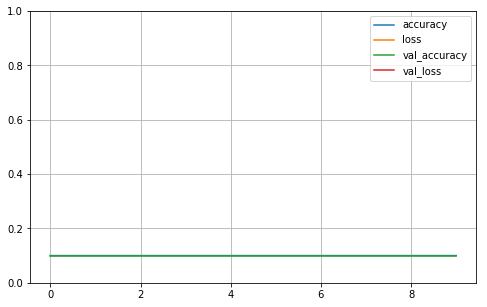

In [27]:
plot_learning_curves(history)

### 2.7)继续训练(在原有的基础上)
Try running `model.fit()` again, and notice that training continues where it left off.

In [28]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 101us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 2/10
55000/55000 [==============================] - 6s 104us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 3/10
55000/55000 [==============================] - 6s 102us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 4/10
55000/55000 [==============================] - 6s 103us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 5/10
55000/55000 [==============================] - 6s 102us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 6/10
55000/55000 [==============================] - 6s 102us/sample - loss: 14.5042 - accuracy: 0.1001 - val_loss: 14.5289 - val_accuracy: 0.0986
Epoch 7/10
55000/55000 [===============

### 2.8)评估模型
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [29]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 52us/sample - loss: 14.5063 - accuracy: 0.1000


[14.50628568725586, 0.1]

### 2.9)做预测
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [30]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

### 2.10)以编号方式显示结果
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [31]:
y_pred = y_proba.argmax(axis=1)
y_pred

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [32]:
y_pred = model.predict_classes(X_new)
y_pred

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

### 2.12)返回每个预测的置信度
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [33]:
y_proba.max(axis=1).round(2)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

### 2.13)按置信度排,显示前三个
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [34]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

array([[5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1],
       [5, 0, 1]])

In [35]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Exercise 3 – Scale the features

### 3.1)对原始数据做归一化处理
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

给所有样本在每一个维度做归一化处理

In [36]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

用现有的函数完成数据的预处理  
只计算训练集的均值和方差,并用它来归一化训练集/验证机和测试集

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

In [43]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 106us/sample - loss: 0.5221 - accuracy: 0.8163 - val_loss: 0.3972 - val_accuracy: 0.8578
Epoch 2/20
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3668 - accuracy: 0.8681 - val_loss: 0.3545 - val_accuracy: 0.8748
Epoch 3/20
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3270 - accuracy: 0.8835 - val_loss: 0.3390 - val_accuracy: 0.8784
Epoch 4/20
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3004 - accuracy: 0.8906 - val_loss: 0.3295 - val_accuracy: 0.8842
Epoch 5/20
55000/55000 [==============================] - 6s 100us/sample - loss: 0.2794 - accuracy: 0.8995 - val_loss: 0.3207 - val_accuracy: 0.8856
Epoch 6/20
55000/55000 [==============================] - 6s 100us/sample - loss: 0.2633 - accuracy: 0.9044 - val_loss: 0.3149 - val_accuracy: 0.8874
Epoch 7/20
55000/55000 [============================

In [38]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 1s 61us/sample - loss: 0.3477 - accuracy: 0.8912


[0.3476964694976807, 0.8912]

### 3.2)绘制学习曲线
Plot the learning curves. Do they look better than earlier?

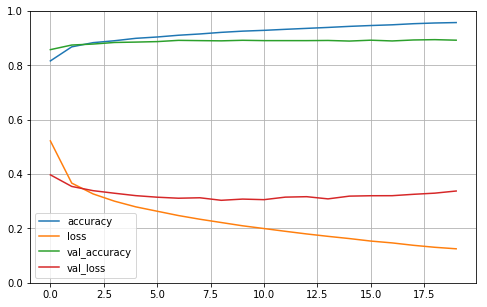

In [44]:
plot_learning_curves(history)

## Exercise 4 – Use Callbacks使用Callbacks机制

### 4.1)记录日志/设置提前终止/保存最佳模型
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [45]:
#创建模型保存路径
root_logdir = os.path.join(os.curdir, "my_logs")

In [58]:
#每运行一次创建一个文件夹保存相关内容
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 6s 103us/sample - loss: 0.0768 - accuracy: 0.9755 - val_loss: 0.3749 - val_accuracy: 0.8964
Epoch 2/50
55000/55000 [==============================] - 6s 100us/sample - loss: 0.0725 - accuracy: 0.9770 - val_loss: 0.4062 - val_accuracy: 0.8868
Epoch 3/50
55000/55000 [==============================] - 6s 100us/sample - loss: 0.0680 - accuracy: 0.9788 - val_loss: 0.4097 - val_accuracy: 0.8946
Epoch 4/50
55000/55000 [==============================] - 6s 101us/sample - loss: 0.0638 - accuracy: 0.9809 - val_loss: 0.3968 - val_accuracy: 0.8946
Epoch 5/50
55000/55000 [==============================] - 5s 100us/sample - loss: 0.0601 - accuracy: 0.9819 - val_loss: 0.4143 - val_accuracy: 0.8928
Epoch 6/50
55000/55000 [==============================] - 6s 101us/sample - loss: 0.0570 - accuracy: 0.9829 - val_loss: 0.4071 - val_accuracy: 0.8918


### 4.2)Tensorboard
The Jupyter plugin for tensorboard was loaded at the beginning of this notebook (`%load_ext tensorboard.notebook`), so you can now simply start it by using the `%tensorboard` magic command. Explore the various tabs available, in particular the SCALARS tab to view learning curves, the GRAPHS tab to view the computation graph, and the PROFILE tab which is very useful to identify bottlenecks if you run into performance issues.

In [53]:
%tensorboard --logdir=./my_logs

### 4.3)加载保存的模型
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [ ]:
model = keras.models.load_model("my_mnist_model.h5")

In [ ]:
model.evaluate(X_valid_scaled, y_valid)

### 4.4)查看跟多关于Callbacks
Look at the list of available callbacks at https://keras.io/callbacks/

## Exercise 5 – A neural net for regression神经网络做回归

### 5.1)加载数据
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [6]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [7]:
print(housing.DESCR)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [8]:
housing.data.shape

(20640, 8)

In [9]:
housing.target.shape

(20640,)

### 5.2)将数据划分为训练集/测试集/验证集
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [10]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [11]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

In [12]:
X_train.shape

(11610, 8)

### 5.3)数据预处理(归一化)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)开始
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

**Tips**:
* Since you are predicting a single value per district (the median house price), there should only be one neuron in the output layer.
* Usually for regression tasks you don't want to use any activation function in the output layer (in some cases you may want to use `"relu"` or `"softplus"` if you want to constrain the predicted values to be positive, or `"sigmoid"` or `"tanh"` if you want to constrain the predicted values to 0-1 or -1-1).
* A good loss function for regression is generally the `"mean_squared_error"` (aka `"mse"`). When there are many outliers in your dataset, you may prefer to use the `"mean_absolute_error"` (aka `"mae"`), which is a bit less precise but less sensitive to outliers.当数据存在异常值时,可以使用"mae"损失,它对异常值不那么敏感.

In [67]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")

In [68]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_valid_scaled, y_valid), epochs=100,
                    callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.7429 - val_loss: 12.0714
Epoch 2/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5715 - val_loss: 2.6598
Epoch 3/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4508 - val_loss: 0.4116
Epoch 4/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4196 - val_loss: 0.4160
Epoch 5/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4031 - val_loss: 0.4180
Epoch 6/100
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3968 - val_loss: 0.4313
Epoch 7/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3905 - val_loss: 0.4237
Epoch 8/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3884 - val_loss: 0.4184
Epoch 9/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.38

In [69]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 22us/sample - loss: 0.3444


0.3443810117568156

In [70]:
model.predict(X_test_scaled)

array([[0.6577164],
       [1.5424004],
       [3.909222 ],
       ...,
       [1.4637735],
       [2.3963661],
       [4.0752544]], dtype=float32)

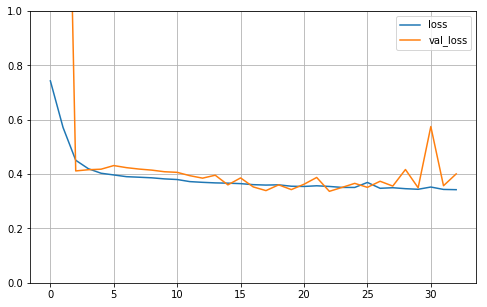

In [71]:
plot_learning_curves(history)

## Exercise 6 – Hyperparameter search超参数

### 6.1)设置不同的学习率,重复学习(用for循环实现)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.  

In [72]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_valid_scaled, y_valid), epochs=100,
                        callbacks=callbacks)
    histories.append(history)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 44us/sample - loss: 5.7611 - val_loss: 9.0942
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 4.3399 - val_loss: 10.3602
Epoch 3/100
11610/11610 [==============================] - 0s 38us/sample - loss: 3.4300 - val_loss: 11.1630
Epoch 4/100
11610/11610 [==============================] - 0s 36us/sample - loss: 2.8060 - val_loss: 11.3103
Epoch 5/100
11610/11610 [==============================] - 0s 41us/sample - loss: 2.3600 - val_loss: 10.6721
Epoch 6/100
11610/11610 [==============================] - 0s 36us/sample - loss: 2.0238 - val_loss: 9.7171
Epoch 7/100
11610/11610 [==============================] - 0s 42us/sample - loss: 1.7628 - val_loss: 8.5812
Epoch 8/100
11610/11610 [==============================] - 0s 38us/sample - loss: 1.5559 - val_loss: 7.4022
Epoch 9/100
11610/11610 [==============================] - 0s 36us/sample - loss: 1

Epoch 15/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4458 - val_loss: 0.4279
Epoch 16/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4415 - val_loss: 0.4238
Epoch 17/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4375 - val_loss: 0.4263
Epoch 18/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4343 - val_loss: 0.4450
Epoch 19/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4303 - val_loss: 0.4128
Epoch 20/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4278 - val_loss: 0.4363
Epoch 21/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4259 - val_loss: 0.4206
Epoch 22/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4231 - val_loss: 0.4407
Epoch 23/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4201 - val_loss: 0.4158
Epoch 24/100
11610/

Learning rate: 0.0001


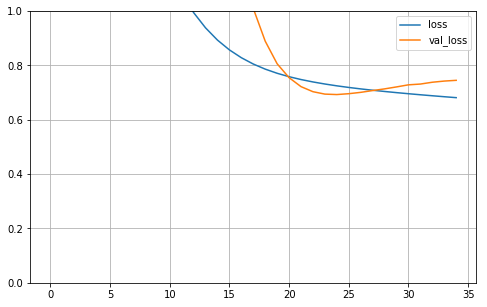

Learning rate: 0.0003


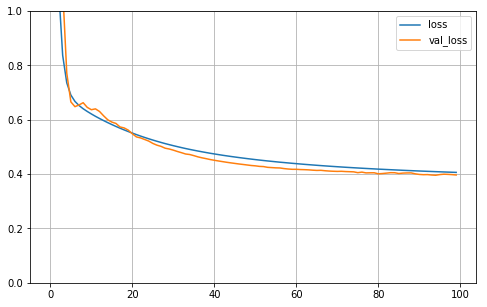

Learning rate: 0.001


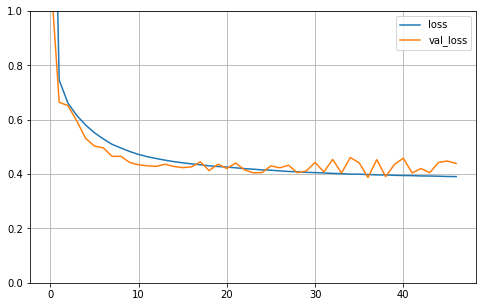

Learning rate: 0.003


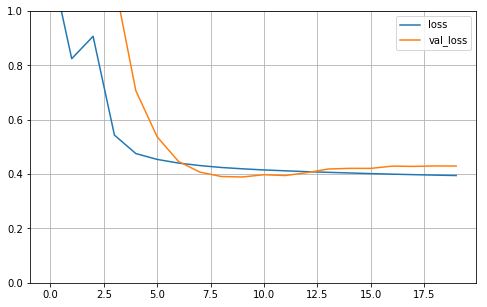

Learning rate: 0.01


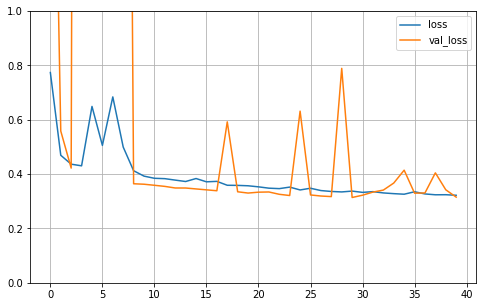

Learning rate: 0.03


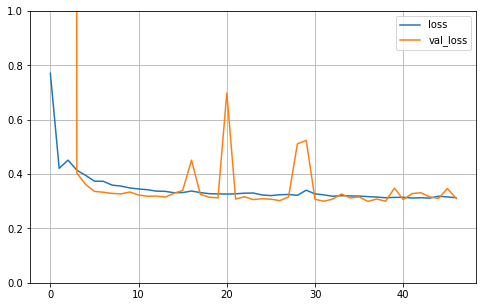

In [73]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_curves(history)

### 6.2)定义一个函数,根据给定的超参数返回一个模型
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [74]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)用keras.wrappers.scikit_learn.KerasRegressor做超参数搜索
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [78]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [92]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 58us/sample - loss: 1.1465 - val_loss: 0.7745
Epoch 2/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5532 - val_loss: 1.4648
Epoch 3/100
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4862 - val_loss: 0.9953
Epoch 4/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4540 - val_loss: 1.0747
Epoch 5/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4354 - val_loss: 0.8391
Epoch 6/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4198 - val_loss: 2.4995
Epoch 7/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4132 - val_loss: 4.1638
Epoch 8/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4095 - val_loss: 3.4948
Epoch 9/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.421

In [80]:
keras_reg.predict(X_test_scaled)

array([0.6485385, 1.4227791, 4.6693296, ..., 1.5066459, 2.2512639,
       4.212013 ], dtype=float32)

In [83]:
keras_reg.model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 30)                270       
_________________________________________________________________
dense_33 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 31        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


### 6.4)sklearn.model_selection.RandomizedSearchCV搜索超参数
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

**Tips**:
* create a `param_distribs` dictionary where each key is the name of a hyperparameter you want to fine-tune (e.g., `"n_hidden"`), and each value is the list of values you want to explore (e.g., `[0, 1, 2, 3]`), or a Scipy distribution from `scipy.stats`.
* You can use the reciprocal distribution for the learning rate (e.g, `reciprocal(3e-3, 3e-2)`).
* Create a `RandomizedSearchCV`, passing the `KerasRegressor` and the `param_distribs` to its constructor, as well as the number of iterations (`n_iter`), and the number of cross-validation folds (`cv`). If you are short on time, you can set `n_iter=10` and `cv=3`. You may also want to set `verbose=2`.
* Finally, call the `RandomizedSearchCV`'s `fit()` method on the training set. Once again you can pass it `n_epochs`, `validation_data` and `callbacks` if you want to.
* The best parameters found will be available in the `best_params_` attribute, the best score will be in `best_score_`, and the best model will be in `best_estimator_`.

In [89]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [90]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [91]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.002488407157606045, n_hidden=3, n_neurons=99 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 100us/sample - loss: 1.6165 - val_loss: 0.9053
Epoch 2/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.6228 - val_loss: 0.5861
Epoch 3/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.5380 - val_loss: 0.4897
Epoch 4/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4807 - val_loss: 0.4288
Epoch 5/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.4385 - val_loss: 0.3996
Epoch 6/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.4126 - val_loss: 0.3923
Epoch 7/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.3958 - val_loss: 0.3915
Epoch 8/100
7740/7740 [==============================] - 1s 71us/sample - los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.1s remaining:    0.0s


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.5459 - val_loss: 3.9574
Epoch 2/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.6339 - val_loss: 1.0726
Epoch 3/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.5454 - val_loss: 0.5599
Epoch 4/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4827 - val_loss: 0.4378
Epoch 5/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.4388 - val_loss: 0.4331
Epoch 6/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.4119 - val_loss: 0.3994
Epoch 7/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.3941 - val_loss: 0.3665
Epoch 8/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.3825 - val_loss: 0.3930
Epoch 9/100
7740/7740 [==============================] - 1s 77us/sample - loss: 0.3748 - val_loss: 0.39

Epoch 57/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.2913 - val_loss: 0.3211
Epoch 58/100
7740/7740 [==============================] - 1s 69us/sample - loss: 0.2903 - val_loss: 0.2939
Epoch 59/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.2894 - val_loss: 0.3084
Epoch 60/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.2880 - val_loss: 0.3114
Epoch 61/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.2879 - val_loss: 0.3472
Epoch 62/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.2871 - val_loss: 0.3740
Epoch 63/100
7740/7740 [==============================] - 1s 70us/sample - loss: 0.2853 - val_loss: 0.3020
Epoch 64/100
7740/7740 [==============================] - 1s 69us/sample - loss: 0.2848 - val_loss: 0.3044
Epoch 65/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.2844 - val_loss: 0.2889
Epoch 66/100
7740/7740 [=============

7740/7740 [==============================] - 0s 58us/sample - loss: 0.2983 - val_loss: 0.4233
Epoch 24/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3012 - val_loss: 0.3155
Epoch 25/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.2955 - val_loss: 0.3118
Epoch 26/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.2959 - val_loss: 0.2993
Epoch 27/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.2957 - val_loss: 0.2968
Epoch 28/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2920 - val_loss: 0.2844
Epoch 29/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.2885 - val_loss: 0.2965
Epoch 30/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.2881 - val_loss: 0.2823
Epoch 31/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.2877 - val_loss: 0.2807
Epoch 32/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 53us/sample - loss: 0.3704 - val_loss: 0.4839
Epoch 25/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3690 - val_loss: 0.3876
Epoch 26/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3651 - val_loss: 0.5987
Epoch 27/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3667 - val_loss: 0.5229
Epoch 28/100
7740/7740 [==============================] - 0s 19us/sample - loss: 0.3654
[CV]  learning_rate=0.0015789157988886887, n_hidden=1, n_neurons=88, total=  12.4s
[CV] learning_rate=0.0015789157988886887, n_hidden=1, n_neurons=88 ...
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 67us/sample - loss: 1.5464 - val_loss: 9.1829
Epoch 2/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.7301 - val_loss: 4.5269
Epoch 3/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6

Epoch 13/100
7740/7740 [==============================] - 0s 43us/sample - loss: nan - val_loss: nan
Epoch 14/100
7740/7740 [==============================] - 0s 21us/sample - loss: nan
[CV]  learning_rate=0.029942072374461212, n_hidden=0, n_neurons=57, total=   5.2s
[CV] learning_rate=0.029942072374461212, n_hidden=0, n_neurons=57 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.6334 - val_loss: 0.7403
Epoch 2/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4227 - val_loss: 0.3985
Epoch 3/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3980 - val_loss: 1.1872
Epoch 4/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3934 - val_loss: 1.8608
Epoch 5/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3780 - val_loss: 0.6270
Epoch 6/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3

7740/7740 [==============================] - 1s 75us/sample - loss: 2.9656 - val_loss: 1.2572
Epoch 2/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.9763 - val_loss: 0.7931
Epoch 3/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.7275 - val_loss: 0.6625
Epoch 4/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.6403 - val_loss: 0.6079
Epoch 5/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5988 - val_loss: 0.5747
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5712 - val_loss: 0.5500
Epoch 7/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.5491 - val_loss: 0.5274
Epoch 8/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5289 - val_loss: 0.5068
Epoch 9/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5108 - val_loss: 0.4864
Epoch 10/100
7740/7740 [==============================] - 

Epoch 78/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3819 - val_loss: 0.3586
Epoch 79/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3815 - val_loss: 0.3583
Epoch 80/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3818 - val_loss: 0.3584
Epoch 81/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3814 - val_loss: 0.3572
Epoch 82/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3809 - val_loss: 0.3566
Epoch 83/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3805 - val_loss: 0.3571
Epoch 84/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3804 - val_loss: 0.3567
Epoch 85/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3801 - val_loss: 0.3561
Epoch 86/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3796 - val_loss: 0.3565
Epoch 87/100
7740/7740 [=============

7740/7740 [==============================] - 0s 45us/sample - loss: 0.4181 - val_loss: 0.3823
Epoch 62/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4177 - val_loss: 0.3827
Epoch 63/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4172 - val_loss: 0.3845
Epoch 64/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4170 - val_loss: 0.3852
Epoch 65/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.4165 - val_loss: 0.3873
Epoch 66/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4156 - val_loss: 0.3896
Epoch 67/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4159 - val_loss: 0.3916
Epoch 68/100
7740/7740 [==============================] - 0s 17us/sample - loss: 0.4149
[CV]  learning_rate=0.002037996779860825, n_hidden=1, n_neurons=3, total=  23.8s
[CV] learning_rate=0.010394502293169707, n_hidden=3, n_neurons=36 ....
Train on 7740 samples, v

7740/7740 [==============================] - 0s 55us/sample - loss: 0.3328 - val_loss: 0.4225
Epoch 13/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.3321 - val_loss: 0.3364
Epoch 14/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3289 - val_loss: 0.3239
Epoch 15/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3308 - val_loss: 0.3603
Epoch 16/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3268 - val_loss: 0.3288
Epoch 17/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3225 - val_loss: 0.3278
Epoch 18/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3174 - val_loss: 0.3441
Epoch 19/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.3187 - val_loss: 0.3069
Epoch 20/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3151 - val_loss: 0.3020
Epoch 21/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 43us/sample - loss: 0.4684 - val_loss: 0.4367
Epoch 18/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4615 - val_loss: 0.4318
Epoch 19/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4554 - val_loss: 0.4304
Epoch 20/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4494 - val_loss: 0.4198
Epoch 21/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4448 - val_loss: 0.4198
Epoch 22/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4401 - val_loss: 0.4168
Epoch 23/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.4367 - val_loss: 0.4234
Epoch 24/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4333 - val_loss: 0.4143
Epoch 25/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4299 - val_loss: 0.4060
Epoch 26/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 39us/sample - loss: 0.3847 - val_loss: 0.3645
Epoch 68/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3844 - val_loss: 0.3585
Epoch 69/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3838 - val_loss: 0.3586
Epoch 70/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.3833 - val_loss: 0.3623
Epoch 71/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3829 - val_loss: 0.3598
Epoch 72/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3822 - val_loss: 0.3598
Epoch 73/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3819 - val_loss: 0.3591
Epoch 74/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3813 - val_loss: 0.3659
Epoch 75/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3811 - val_loss: 0.3559
Epoch 76/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 63us/sample - loss: 0.3218 - val_loss: 0.3231
Epoch 50/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.3208 - val_loss: 0.3611
Epoch 51/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.3178
[CV]  learning_rate=0.0019693141841199925, n_hidden=2, n_neurons=72, total=  23.9s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.5min finished


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.6984 - val_loss: 0.4571
Epoch 2/100
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4073 - val_loss: 0.6129
Epoch 3/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3800 - val_loss: 1.0873
Epoch 4/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3678 - val_loss: 0.3883
Epoch 5/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3549 - val_loss: 0.3725
Epoch 6/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.3457 - val_loss: 0.5034
Epoch 7/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3419 - val_loss: 1.0657
Epoch 8/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.3509 - val_loss: 0.9307
Epoch 9/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.337

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f286c39c0b8>,
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f28345d3668>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [ ]:
rnd_search_cv.score(X_test_scaled, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("my_fine_tuned_housing_model.h5")

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

## Exercise 7 – The functional API构建更复杂的网络

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)The functional API
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a **`keras.layers.Input`** layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the **`keras.layers.concatenate()`** function to concatenate the input layer and the second hidden layer's output.
* Create a **`keras.models.Model`** and specify its **`inputs`** and **`outputs`** (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

In [14]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [15]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [16]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.8652 - val_loss: 7.5667
Epoch 2/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4994 - val_loss: 4.0433
Epoch 3/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4573 - val_loss: 39.4784
Epoch 4/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6061 - val_loss: 83.2630
Epoch 5/10
11610/11610 [==============================] - 1s 49us/sample - loss: 2.1997 - val_loss: 92.8310
Epoch 6/10
11610/11610 [==============================] - 1s 46us/sample - loss: 0.6226 - val_loss: 2.3052
Epoch 7/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4924 - val_loss: 96.2339
Epoch 8/10
11610/11610 [==============================] - 0s 42us/sample - loss: 1.3907 - val_loss: 48.6637
Epoch 9/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.6665 - 

In [19]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 23us/sample - loss: 0.4239


0.4238766202168871

In [20]:
model.predict(X_test_scaled)

array([[0.7571695],
       [1.8719691],
       [3.676588 ],
       ...,
       [1.4134822],
       [2.3514078],
       [3.8639586]], dtype=float32)

### 7.2)Subclassing API
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a **subclass of the `keras.models.Model`** class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the **`input`** in the **`call()`** method, and return the **output**.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. **You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.**
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. **Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.**

In [21]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [22]:
model.compile(loss="mse", optimizer="sgd")

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.7092 - val_loss: 32.7654
Epoch 2/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.5270 - val_loss: 17.3639
Epoch 3/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4872 - val_loss: 38.3491
Epoch 4/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5775 - val_loss: 64.5569
Epoch 5/10
11610/11610 [==============================] - 0s 40us/sample - loss: 1.2878 - val_loss: 1.4285
Epoch 6/10
11610/11610 [==============================] - 0s 43us/sample - loss: 1.4068 - val_loss: 82.0180
Epoch 7/10
11610/11610 [==============================] - 0s 39us/sample - loss: 1.8597 - val_loss: 0.4204
Epoch 8/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.8322 - val_loss: 251.8108
Epoch 9/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.7678 

In [24]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.evaluate(X_test_scaled, y_test)

5160/5160 [==============================] - 0s 26us/sample - loss: 0.6087


0.6086793074312136

In [26]:
model.predict(X_test_scaled)

array([[0.665951 ],
       [1.7603348],
       [3.4175048],
       ...,
       [1.4975803],
       [2.5738883],
       [3.7763305]], dtype=float32)

### 7.3)用functional API下图的网络(多个输入)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

In [27]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [28]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [29]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [30]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           210         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 30)           930         dense_6[0][0]                    
____________________________________________________________________________________________

In [32]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [33]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 56us/sample - loss: 0.7982 - val_loss: 2.1800
Epoch 2/10
11610/11610 [==============================] - 1s 46us/sample - loss: 0.4905 - val_loss: 0.7628
Epoch 3/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4416 - val_loss: 3.3136
Epoch 4/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4857 - val_loss: 0.9585
Epoch 5/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4203 - val_loss: 0.5910
Epoch 6/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4082 - val_loss: 1.1373
Epoch 7/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4042 - val_loss: 1.3463
Epoch 8/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4085 - val_loss: 0.4331
Epoch 9/10
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3918 - val_l

In [ ]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

In [ ]:
model.predict([X_test_scaled_A, X_test_scaled_B])

### 7.4)多个输入和多个输出
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* **Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.**
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify **`loss_weights=[0.9, 0.1]`**.不同损失的加权和.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

In [34]:
input_A = keras.layers.Input(shape=X_train_scaled_A.shape[1:])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [35]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [36]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer="sgd")

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

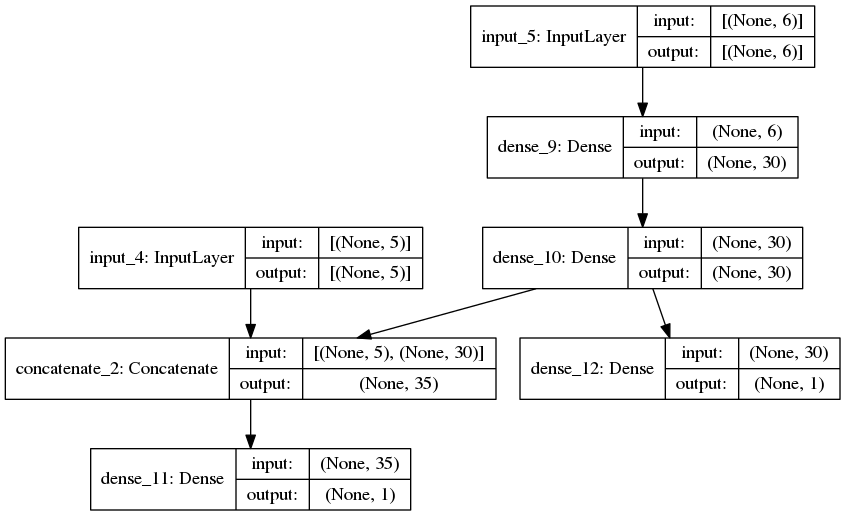

In [38]:
keras.utils.plot_model(model,'functional_api_model.png',show_shapes=True)

In [39]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 86us/sample - loss: 0.8687 - dense_11_loss: 0.7754 - dense_12_loss: 1.7095 - val_loss: 6.8791 - val_dense_11_loss: 7.5792 - val_dense_12_loss: 1.0991
Epoch 2/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5415 - dense_11_loss: 0.4916 - dense_12_loss: 0.9902 - val_loss: 5.1960 - val_dense_11_loss: 5.6707 - val_dense_12_loss: 0.8985
Epoch 3/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.5243 - dense_11_loss: 0.4872 - dense_12_loss: 0.8575 - val_loss: 0.6477 - val_dense_11_loss: 0.3960 - val_dense_12_loss: 2.9113
Epoch 4/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.4595 - dense_11_loss: 0.4254 - dense_12_loss: 0.7661 - val_loss: 0.5860 - val_dense_11_loss: 0.5431 - val_dense_12_loss: 0.9729
Epoch 5/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.4446 - dense_11_loss: 0.

In [40]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

5160/5160 [==============================] - 0s 39us/sample - loss: 0.3993 - dense_11_loss: 0.3837 - dense_12_loss: 0.5391


[0.3992860531622125, 0.38366613, 0.53914607]

In [41]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [42]:
y_pred

array([[0.67121965],
       [2.073535  ],
       [3.5211577 ],
       ...,
       [1.4858576 ],
       [2.3110967 ],
       [3.745615  ]], dtype=float32)

In [43]:
y_pred_aux

array([[1.0318   ],
       [2.2188723],
       [3.1979525],
       ...,
       [1.3228676],
       [1.5755787],
       [3.0700412]], dtype=float32)

## Exercise 8 – Deep Nets深层网络

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [44]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

### 8.1)用for循环添加网络层数
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 11s 199us/sample - loss: 2.2559 - accuracy: 0.1667 - val_loss: 1.8844 - val_accuracy: 0.2266
Epoch 2/10
55000/55000 [==============================] - 10s 175us/sample - loss: 1.0269 - accuracy: 0.5965 - val_loss: 0.6073 - val_accuracy: 0.7864
Epoch 3/10
55000/55000 [==============================] - 10s 175us/sample - loss: 0.5830 - accuracy: 0.7879 - val_loss: 0.5798 - val_accuracy: 0.8022
Epoch 4/10
55000/55000 [==============================] - 10s 174us/sample - loss: 0.4784 - accuracy: 0.8355 - val_loss: 0.4334 - val_accuracy: 0.8558
Epoch 5/10
55000/55000 [==============================] - 10s 176us/sample - loss: 0.4216 - accuracy: 0.8566 - val_loss: 0.4159 - val_accuracy: 0.8586
Epoch 6/10
55000/55000 [==============================] - 10s 179us/sample - loss: 0.3869 - accuracy: 0.8687 - val_loss: 0.3996 - val_accuracy: 0.8670
Epoch 7/10
55000/55000 [=====================

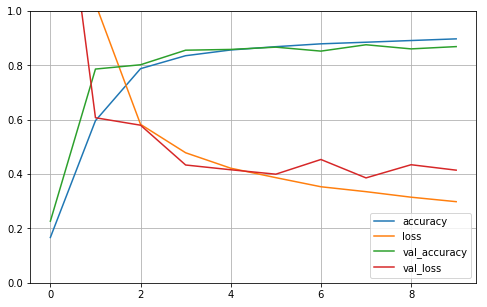

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.2)在每个全连接层添加一个batch_normalize
Update the model to add a **`BatchNormalization`** layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 27s 495us/sample - loss: 1.0970 - accuracy: 0.6208 - val_loss: 0.6379 - val_accuracy: 0.7660
Epoch 2/10
55000/55000 [==============================] - 23s 411us/sample - loss: 0.7500 - accuracy: 0.7375 - val_loss: 0.5309 - val_accuracy: 0.8156
Epoch 3/10
55000/55000 [==============================] - 23s 415us/sample - loss: 0.6425 - accuracy: 0.7768 - val_loss: 0.4802 - val_accuracy: 0.8312
Epoch 4/10
55000/55000 [==============================] - 23s 415us/sample - loss: 0.5861 - accuracy: 0.7973 - val_loss: 0.4363 - val_accuracy: 0.8464
Epoch 5/10
55000/55000 [==============================] - 23s 410us/sample - loss: 0.5382 - accuracy: 0.8147 - val_loss: 0.4206 - val_accuracy: 0.8558
Epoch 6/10
55000/55000 [==============================] - 23s 427us/sample - loss: 0.5058 - accuracy: 0.8237 - val_loss: 0.3899 - val_accuracy: 0.8654
Epoch 7/10
55000/55000 [=====================

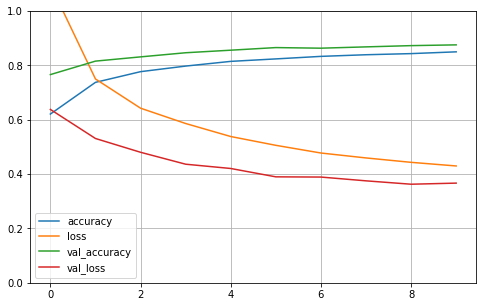

In [49]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_56 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)              

### 8.3)将BN添加到Activation之前
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 28s 508us/sample - loss: 1.0132 - accuracy: 0.6407 - val_loss: 0.6283 - val_accuracy: 0.7726
Epoch 2/10
55000/55000 [==============================] - 22s 403us/sample - loss: 0.6688 - accuracy: 0.7610 - val_loss: 0.4968 - val_accuracy: 0.8186
Epoch 3/10
55000/55000 [==============================] - 22s 400us/sample - loss: 0.5781 - accuracy: 0.7971 - val_loss: 0.4411 - val_accuracy: 0.8412
Epoch 4/10
55000/55000 [==============================] - 21s 389us/sample - loss: 0.5220 - accuracy: 0.8177 - val_loss: 0.4123 - val_accuracy: 0.8512
Epoch 5/10
55000/55000 [==============================] - 22s 400us/sample - loss: 0.4834 - accuracy: 0.8299 - val_loss: 0.3792 - val_accuracy: 0.8642
Epoch 6/10
55000/55000 [==============================] - 22s 407us/sample - loss: 0.4640 - accuracy: 0.8365 - val_loss: 0.3798 - val_accuracy: 0.8688
Epoch 7/10
55000/55000 [=====================

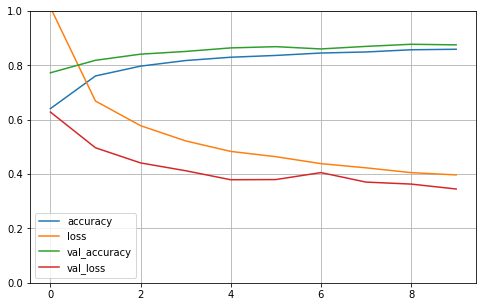

In [51]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.4)移除BN,使用SELU作为激活层(和lecun_normal一起用)
Remove all the BN layers, and just use the SELU activation function instead (always use SELU with LeCun Normal weight initialization). Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)  
训练的速度更快,效果更好

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

### 8.5)Dropout在输出层前加
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 22s 406us/sample - loss: 0.3807 - accuracy: 0.8652 - val_loss: 0.3561 - val_accuracy: 0.8778
Epoch 2/10
55000/55000 [==============================] - 22s 397us/sample - loss: 0.3686 - accuracy: 0.8678 - val_loss: 0.3426 - val_accuracy: 0.8836
Epoch 3/10
55000/55000 [==============================] - 22s 406us/sample - loss: 0.3618 - accuracy: 0.8707 - val_loss: 0.3437 - val_accuracy: 0.8790
Epoch 4/10
55000/55000 [==============================] - 22s 392us/sample - loss: 0.3505 - accuracy: 0.8759 - val_loss: 0.3397 - val_accuracy: 0.8764
Epoch 5/10
55000/55000 [==============================] - 23s 411us/sample - loss: 0.3475 - accuracy: 0.8765 - val_loss: 0.3370 - val_accuracy: 0.8792
Epoch 6/10
55000/55000 [==============================] - 22s 408us/sample - loss: 0.3397 - accuracy: 0.8800 - val_loss: 0.3239 - val_accuracy: 0.8850
Epoch 7/10
55000/55000 [=====================

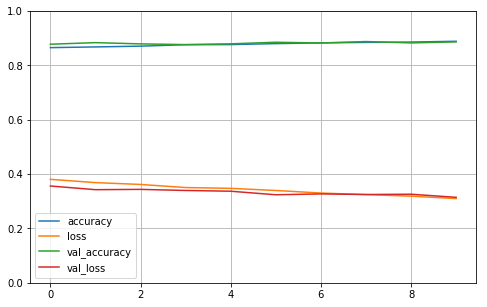

In [52]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 16s 293us/sample - loss: 0.6650 - accuracy: 0.7805 - val_loss: 0.6127 - val_accuracy: 0.8548
Epoch 2/20
55000/55000 [==============================] - 14s 255us/sample - loss: 0.4378 - accuracy: 0.8521 - val_loss: 0.6016 - val_accuracy: 0.8666
Epoch 3/20
55000/55000 [==============================] - 14s 248us/sample - loss: 0.3894 - accuracy: 0.8663 - val_loss: 0.5271 - val_accuracy: 0.8640
Epoch 4/20
55000/55000 [==============================] - 14s 250us/sample - loss: 0.3559 - accuracy: 0.8756 - val_loss: 0.4925 - val_accuracy: 0.8782
Epoch 5/20
55000/55000 [==============================] - 14s 254us/sample - loss: 0.3298 - accuracy: 0.8858 - val_loss: 0.5240 - val_accuracy: 0.8808
Epoch 6/20
55000/55000 [==============================] - 14s 250us/sample - loss: 0.3142 - accuracy: 0.8886 - val_loss: 0.5353 - val_accuracy: 0.8780
Epoch 7/20
55000/55000 [=====================

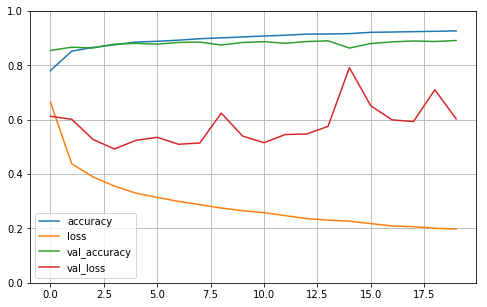

In [53]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))
plot_learning_curves(history)